In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numba import jit, vectorize, float64, int64
import warnings
warnings.filterwarnings('ignore')

In [3]:
def gradlogistic(X,Y,theta,n,V):  
    #theta is updated
    #X,Y are samples from the minibatch
    #n is total number of observations
    #V should be provided ahead, specified here
    Vinv = np.linalg.inv(V)
    d1 = -np.diag(Y-1/(1+np.exp(-X@theta)))@X
    d2 = Vinv@theta
    d1_avg = d1.mean(axis = 0)
    return d1_avg*n + d2

In [4]:
def generate_data(nrow,ncol):
    np.random.seed(1234)
    X=np.random.normal(0,1,[nrow,ncol])  
    Y=np.random.binomial(1,1/(1+np.exp(-(X@theta))))
    train=np.random.choice(range(nrow),int(nrow/2),replace=False)
    test=np.array(list(set(range(nrow))-set(train)))
    return X, Y, train,test

In [5]:
np.random.seed(1234)
theta=np.array([-5,10,5,20,30]) 
X,Y,train,test = generate_data(20000,5)

In [6]:
X_train=X[train,:]
Y_train=Y[train]
X_test=X[test,:]
Y_test=Y[test]

In [7]:
def test_err(theta):
    err = []
    for i in points:
        pro = 1/(1+np.exp(-(X_test @ theta[:i,:].T)))
        pred = np.random.binomial(1,pro)
        coverage = np.mean(pred == Y_test[:,None])
        err.append(1-coverage)
    return(err)

In [8]:
def batch(X,Y, nbatch):
    nrow = X.shape[0]
    idx = np.random.choice(nrow, nbatch, replace = False)
    X_sample = X[idx,:]
    Y_sample = Y[idx]
    return X_sample, Y_sample

## SGLD

In [9]:
def sgld(X,Y,theta0,M,C,V,eps,nbatch,niter=2000):
    n,p=X.shape
    theta=theta0
    theta_save=np.zeros([niter,p])
    np.random.seed(10)
    for t in range(niter): 
        X_sample,Y_sample = batch(X,Y,nbatch)
        theta=theta-gradlogistic(X_sample,Y_sample,theta,n,V)*eps+np.random.multivariate_normal(np.zeros(p),np.sqrt(2*0.01*np.eye(p)),1).ravel()
        theta_save[t,:]=theta
    return theta_save

In [10]:
theta0 = np.zeros(5)
M = C = np.eye(5)
nbatch=500
eps=.001
V = np.diag([20,20,20,20,20])

In [11]:
points = np.arange(1,2010,100)

In [12]:
sgld_theta=sgld(X_train,Y_train,theta0,M,C,V,eps,nbatch,2000)

In [13]:
sglderr = test_err(sgld_theta)

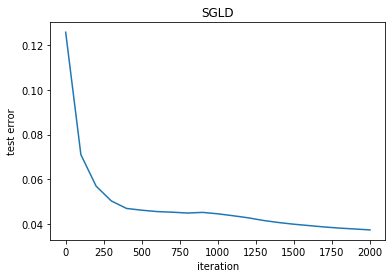

In [14]:
plt.plot(points,sglderr)
plt.xlabel("iteration")
plt.ylabel("test error")
plt.title("SGLD")
plt.savefig("SGLD")

## SGHMC

In [15]:
@jit
def batch_numba(X,Y, nbatch):
    nrow = X.shape[0]
    idx = np.random.choice(nrow, nbatch, replace = False)
    X_sample = X[idx,:]
    Y_sample = Y[idx]
    return X_sample, Y_sample

In [16]:
@jit([float64[:,:](float64[:],float64[:,:],float64[:],int64,float64[:],float64[:,:],float64[:,:],float64[:,:],float64,int64,int64)],cache = True)
def sghmc_numba(theta0,X,Y,nbatch,gradU,M,C,V,eps,step = 10, niter = 10):
    B = 1/2 * V * eps
    sigma = np.sqrt(2*eps*(C-B))
    n, p = X.shape
    theta = theta0 #set an initial value of theta
    thetas =np.zeros([step,p])
    Minv = np.linalg.inv(M)
    np.random.seed(10)
    #simulate dynamics
    for t in range(step):
        r = np.random.multivariate_normal(np.zeros(p),np.sqrt(M))
        for i in range(niter):
            theta = theta + eps*Minv@r
            X_sample,Y_sample = batch_numba(X,Y,nbatch)
            r =  r - eps*gradU(X_sample, Y_sample,theta,n,V) - eps*C @ Minv @ r 
            + np.random.multivariate_normal(np.zeros(p),sigma,1).ravel()
        thetas[t,:] = theta
    return thetas

In [17]:
theta0 = np.zeros(5)
M = C = np.eye(5)
nbatch=500
eps=.001
V = np.diag([20,20,20,20,20])

In [18]:
sghmc_theta = sghmc_numba(np.zeros(5),X_train,Y_train,nbatch,gradlogistic,M,C,V,eps,2000,50)

In [19]:
sghmcerr = test_err(sghmc_theta)

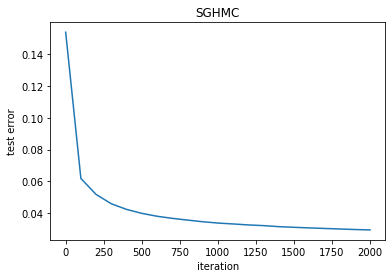

In [20]:
plt.plot(points,sghmcerr)
plt.xlabel("iteration")
plt.ylabel("test error")
plt.title("SGHMC")
plt.savefig("SGHMC")

## SGD (simplied version, without momentum)

In [21]:
def gradlogistic_1(x,y,theta,n,V):  
    #theta is updated
    #X,Y are samples from the minibatch
    #n is total number of observations
    #V should be provided ahead, specified here
    Vinv = np.linalg.inv(V)
    d1 = -np.diag([(y-1/(1+np.exp(-x@theta)))])@x[None,:]
    d2 = Vinv@theta
    return d1 + d2

In [22]:
def sgd(X_train,y_train,nbatch,learning_rate,theta0, ninte):
    theta = theta0
    n,p = X_train.shape
    thetas = np.zeros([ninte,p])
    for i in range(ninte):
        grad = gradlogistic_1(X_train[i,:],y_train[i],theta0,1,V)
        theta = theta - learning_rate * grad
        thetas[i] = theta
    return thetas

In [23]:
theta0 = np.zeros(5)
M = C = np.eye(5)
nbatch=500
eps=.001
V = np.diag([20,20,20,20,20])

In [24]:
sgd_theta = sgd(X_train,Y_train,500,0.05,theta0,2000)

In [25]:
sgderr = test_err(sgd_theta)

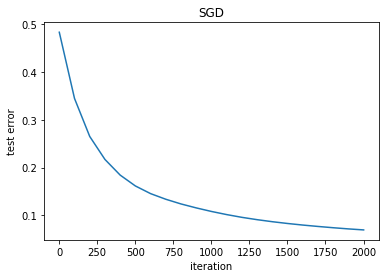

In [26]:
plt.plot(points, sgderr)
plt.xlabel("iteration")
plt.ylabel("test error")
plt.title("SGD")
plt.savefig("SGD")

## Compare

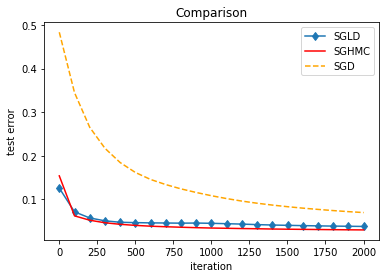

In [27]:
plt.plot(points,sglderr,"d-")
plt.plot(points,sghmcerr,color = "red")
plt.plot(points, sgderr, '--',color = "orange")
plt.legend(['SGLD','SGHMC','SGD'])
plt.xlabel("iteration")
plt.ylabel("test error")
plt.title("Comparison")
plt.savefig("Comparison")

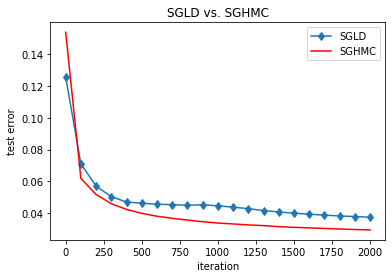

In [28]:
plt.plot(points,sglderr,"d-")
plt.plot(points,sghmcerr,color = "red")
plt.legend(['SGLD','SGHMC'])
plt.xlabel("iteration")
plt.ylabel("test error")
plt.title("SGLD vs. SGHMC")
plt.savefig("SGLDvsSGHMC")